# Controllability Analysis of Mill Discharge Circuit

In [1]:
from __future__ import print_function
import numpy as np
import sympy as sp
import scipy as sc
import numpy.linalg as nplinalg
import scipy.linalg as sclinalg
import matplotlib.pyplot as plt
import utils
import itertools
import project_utils
from sympy import latex, I
from math import log10, floor
from scipy.optimize import minimize
from functools import partial
from ipywidgets import interact
import ipywidgets as widgets

#from IPython.display                    import display, Math, Latex
%matplotlib inline
from sympy import *
init_printing(num_columns = 100)
#sp.init_printing(use_latex = True)
sp.init_printing(use_latex = 'Matjax')

# 1. Model Formulation

### Process and Disturbance Variables

u = [SFW, SP, SuFW, RFF, SF]

y = [SL, CFD, RFD, SuL]

### Process Parameters

In [2]:
G_VF_SF = 0.03
O_VF_SF = 76.5
t_VF_SF = 87.92
G_SL_SF = 6e-4
O_SL_SF = 121
t_SL_SF = 90
G_CFD_SF = 1.8e-7
O_CFD_SF = 124
C_CFD_SF = 0.0285
G_SL_SFW = 0.0011
O_SL_SFW = 0.415
G_CFD_SFW = -8e-4
O_CFD_SFW = 0.363
t_CFD_SFW = 64.5
G_SL_SP = -0.0078
G_CFF_SP = 14.8
O_CFF_SP = 0.56
t_CFF_SP = 1.02
G_CFP_SP = 0.9
O_CFP_SP = 0.614
t_CFP_SP = 0.97
G_SuL_SuFW = 7e-5
O_SuL_SuFW = 0.415
G_SuL_RFF = -7e-5
O_SuL_RFF = 6.26
G_RFD_SuFW = -3e-4
O_RFD_SuFW = 5.81
t_RFD_SuFW = 1083.7
G_RFD_CFD = 1
O_RFD_CFD = 2.49
t_RFD_CFD = 1422.9
G_SuL_CFF = 3e-5
O_SuL_CFF = 0.698

### System and Distrurbance Transfer Function with and without deadtime

In [3]:
s = sp.Symbol('s')

def model_with_deadtime():
    # y = [VF, SL, CFF, CFD, CFP, SuL, RFD]
    # u = [SF, SP, SuFW, RFF]
    # d = [SFW]

    VF_SF    = (G_VF_SF * exp(-O_VF_SF*s)) / (t_VF_SF * s + 1)
    SL_SF    = (G_SL_SF * exp(-O_SL_SF*s)) / (s * (t_SL_SF * s + 1))
    CFD_SF   = (G_CFD_SF * exp(-O_CFD_SF*s)) / (s * (s + C_CFD_SF))
    RFD_SF   = (G_RFD_CFD * G_CFD_SF * exp(-(O_RFD_CFD + O_CFD_SF)*s)) / (s * (t_RFD_CFD * s + 1) * (s + C_CFD_SF))
    SL_SP    = G_SL_SP / s
    CFF_SP   = (G_CFF_SP * exp(-O_CFF_SP*s)) / (t_CFF_SP * s + 1)
    CFP_SP   = (G_CFP_SP * exp(-O_CFP_SP*s)) / (t_CFP_SP * s + 1)
    SuL_SP   = (G_SuL_CFF  * G_CFF_SP * exp(-(O_SuL_CFF + O_CFF_SP)*s)) / (s)
    SuL_SuFW = (G_SuL_SuFW * exp(-O_SuL_SuFW*s)) / s
    RFD_SuFW = (G_RFD_SuFW * exp(-O_RFD_SuFW*s)) / (t_RFD_SuFW * s + 1)
    SuL_RFF  = (G_SuL_RFF * exp(-O_SuL_RFF*s)) / s

    G = sp.Matrix([[0, VF_SF, 0, 0],
                   [SL_SP, SL_SF, 0, 0],
                   [CFF_SP, 0, 0, 0],
                   [0, CFD_SF, 0, 0],
                   [CFP_SP, 0, 0, 0],
                   [SuL_SP, 0, SuL_RFF, SuL_SuFW],
                   [0, RFD_SF, 0, RFD_SuFW]])
    
    SL_SFW   = (G_SL_SFW * exp(-O_SL_SFW*s))/ s
    CFD_SFW  = (G_CFD_SFW * exp(-O_CFD_SFW*s))/((t_CFD_SFW * s + 1)*(s-1))
    RFD_SFW  = (G_RFD_CFD  * G_CFD_SFW * exp(-(O_RFD_CFD + O_CFD_SFW)*s))/((t_RFD_CFD * s + 1) * (t_CFD_SFW * s + 1) * (s - 1))  
    
    Gd = sp.Matrix([[0],[SL_SFW],[0],[CFD_SFW],[0],[0],[RFD_SFW]])
    
    return G,Gd

def model_no_deadtime():
    # y = [VF, SL, CFF, CFD, CFP, SuL, RFD]
    # u = [SF, SP, SuFW, RFF]
    # d = [SFW]

    VF_SF    = (G_VF_SF) / (t_VF_SF * s + 1)
    SL_SF    = (G_SL_SF) / (s * (t_SL_SF * s + 1))
    CFD_SF   = (G_CFD_SF) / (s * (s + C_CFD_SF))
    CFF_SP   = (G_CFF_SP) / (t_CFF_SP * s + 1)
    CFP_SP   = (G_CFP_SP) / (t_CFP_SP * s + 1)
    RFD_SF   = (G_RFD_CFD * G_CFD_SF) / (s * (t_RFD_CFD * s + 1) * (s + C_CFD_SF))
    SL_SP    = G_SL_SP / s
    SuL_SP   = (G_SuL_CFF * G_CFF_SP) / (s)
    SuL_SuFW = (G_SuL_SuFW) / s
    RFD_SuFW = (G_RFD_SuFW) / (t_RFD_SuFW * s + 1)
    SuL_RFF  = (G_SuL_RFF) / s
    
    
    G = sp.Matrix([[0, VF_SF, 0, 0],
                   [SL_SP, SL_SF, 0, 0],
                   [CFF_SP, 0, 0, 0],
                   [0, CFD_SF, 0, 0],
                   [CFP_SP, 0, 0, 0],
                   [SuL_SP, 0, SuL_RFF, SuL_SuFW],
                   [0, RFD_SF, 0, RFD_SuFW]])
        
    SL_SFW   = (G_SL_SFW)/ s
    CFD_SFW  = (G_CFD_SFW)/((t_CFD_SFW * s + 1)*(s-1))
    RFD_SFW  = (G_RFD_CFD * G_CFD_SFW)/((t_RFD_CFD * s + 1) * (t_CFD_SFW * s + 1) * (s - 1))
    
    Gd = sp.Matrix([[0],[SL_SFW],[0],[CFD_SFW],[0],[0],[RFD_SFW]])

    return G,Gd

def model_deadtime():
    
    G_theta = np.matrix([[0, O_VF_SF, 0, 0],
                         [0, O_SL_SF, 0, 0],
                         [O_CFF_SP, 0, 0, 0],
                         [0, O_CFD_SF, 0, 0],
                         [O_CFP_SP, 0, 0, 0],
                         [O_SuL_CFF + O_CFF_SP, 0, O_SuL_RFF, O_SuL_SuFW],
                         [0, O_RFD_CFD+O_CFD_SF, 0, O_RFD_SuFW]])
    
    Gd_theta = np.matrix([[0],
                          [O_SL_SFW],
                          [0],
                          [O_CFD_SFW],
                          [0],
                          [0],
                          [O_RFD_CFD + O_CFD_SFW]])
    
    return G_theta, Gd_theta

In [4]:
G_hat,      Gd_hat      = model_no_deadtime()      # used only for scaling purposes
G_hat_dead, Gd_hat_dead = model_with_deadtime()    # used to print and display what model MIMO tf matrix looks like
print("Mimo transfer function matrix of system: \n")
print(pretty(G_hat_dead, use_unicode=False))
print("\n\n Mimo transfer function matrix of disturbance: ")
print(pretty(Gd_hat_dead,use_unicode=False))

Mimo transfer function matrix of system: 

[                                  -76.5*s                                              ]
[                            0.03*e                                                     ]
[        0                   -------------                  0                  0        ]
[                             87.92*s + 1                                               ]
[                                                                                       ]
[                                   -121*s                                              ]
[     -0.0078               0.0006*e                                                    ]
[     --------              --------------                  0                  0        ]
[        s                   s*(90*s + 1)                                               ]
[                                                                                       ]
[        -0.56*s                                         

# 2. Scale variables

In [5]:
def scale(G_hat,Gd_hat,AddDeadtime=False):
    # y = [VF, SL, CFF, CFD, CFP, SuL, RFD]
    # u = [SP, SF, RFF, SuFW]
    # d = [SFW]
    
    e_hat_max = np.array([30, 20, 600, 0.3, 20, 25, 0.13])
    De        = np.diag(e_hat_max)
    #print("De = ",De)
    
    u_hat_max = np.array([25, 450, 1000, 200])
    Du        = np.diag(u_hat_max)
    #print("Du = ",Du)
    
    d_hat_max = np.array([350])
    Dd        = np.diag(d_hat_max)
    #print("Dd = ",Dd)
    
    G_scaled  = project_utils.round_coeff_matrix(nplinalg.inv(De)*(G_hat)*(Du))
    Gd_scaled = project_utils.round_coeff_matrix(nplinalg.inv(De)*(Gd_hat)*(Dd))

    if AddDeadtime == True:
        G, Gd = add_deadtime(G_scaled, Gd_scaled)
    else:
        G = G_scaled
        Gd = Gd_scaled
        
    return G,Gd

def scale_utils(G_hat_utils,Gd_hat_utils):
    # y = [VF, SL, CFF, CFD, CFP, SuL, RFD]
    # u = [SP, SF, RFF, SuFW]
    # d = [SFW]
    
    e_hat_max = np.array([30, 20, 600, 0.3, 20, 25, 0.13])
    De        = np.diag(e_hat_max)
    De_inv    = nplinalg.inv(De)
    De_inv_utils    = [[] for r in range(De_inv.shape[0])]
    
    for r in range(De_inv.shape[0]):
        for c in range(De_inv.shape[1]):
            De_inv_utils[r].append(utils.tf([De_inv[r,c]]))
    De_inv_mimo = utils.mimotf(De_inv_utils)

    
    u_hat_max = np.array([25, 450, 1000, 200])
    Du        = np.diag(u_hat_max)
    Du_utils    = [[] for r in range(Du.shape[0])]
    
    for r in range(Du.shape[0]):
        for c in range(Du.shape[1]):
            Du_utils[r].append(utils.tf([Du[r,c]]))
    Du_mimo = utils.mimotf(Du_utils)

    
    d_hat_max = np.array([350])
    Dd        = np.diag(d_hat_max)
    Dd_utils    = [[] for r in range(Dd.shape[0])]
    
    for r in range(Dd.shape[0]):
        for c in range(Dd.shape[1]):
            Dd_utils[r].append(utils.tf([Dd[r,c]]))
    Dd_mimo = utils.mimotf(Dd_utils)
    
    G_utils_scaled  = De_inv_mimo*(G_hat_utils)*(Du_mimo)
    Gd_utils_scaled = De_inv_mimo*(Gd_hat_utils)*(Dd_mimo)

    return G_utils_scaled,Gd_utils_scaled

def add_deadtime(G,Gd, G_deadtime = None, Gd_deadtime = None):
    
    if (G_deadtime is None) or (Gd_deadtime is None):
        G_deadtime, Gd_deadtime = model_deadtime()
    
    Grows, Gcols   = G.shape
    Gdrows, Gdcols = Gd.shape
    
    G_dead  = sp.zeros(Grows,Gcols)
    Gd_dead = sp.zeros(Gdrows,Gdcols)
    
    for cG in range(Gcols):
        for rG in range(Grows):
            G_dead[rG,cG] = G[rG,cG] * exp(-G_deadtime[rG,cG]*s)
    for rGd in range(Gdrows):
        for cGd in range(Gdcols):
            Gd_dead[rGd,cGd] = Gd[rGd,cGd] * exp(-Gd_deadtime[rGd,cGd]*s)
        
    return G_dead, Gd_dead


In [6]:
G, Gd           = scale(G_hat,Gd_hat)
G_dead, Gd_dead = scale(G_hat,Gd_hat,AddDeadtime = True)

print("\nMimo transfer function matrix of the system: \n")
print(pretty(G_dead, use_unicode=False))
print("\n\n Mimo transfer function matrix of the disturbance: ")
print(pretty(Gd_dead,use_unicode=False))


Mimo transfer function matrix of the system: 

[                               -76.5*s                                             ]
[                          0.4*e                                                    ]
[       0                  ------------                  0                 0        ]
[                          87.9*s + 1.0                                             ]
[                                                                                   ]
[                               -121.0*s                                            ]
[     -0.01               0.01*e                                                    ]
[     ------             ----------------                0                 0        ]
[       s                s*(90.0*s + 1.0)                                           ]
[                                                                                   ]
[       -0.56*s                                                                     ]
[  0.6

# 3. Minimal Realisation

In [7]:
def pole_zero_cancel(G, add_deadtime = False):
    
    rows, cols = G.shape
    G_minimal = sp.zeros(rows,cols)
    
    G_deadtime,_ = model_deadtime()
    
    for c in range(cols):
        for r in range(rows):
            
            G[r,c] = G[r,c].simplify()
                
            if add_deadtime == True:
                G_minimal[r,c] = G[r,c] * exp(-G_deadtime[r,c]*s)
            else:
                G_minimal[r,c] = G[r,c]
                
    return G_minimal

In [8]:
G_minimal = pole_zero_cancel(G, add_deadtime = True)
print("Minimal realisation for of system MIMO transfer function matrix: \n")
print(pretty(G_minimal, use_unicode=False))
print('\n \nBy inspection the MIMO transfer function model was already a minimal realisation, as there are no zeros in any of the SISO \ntransfer functions. This result verifies the observation') 

Minimal realisation for of system MIMO transfer function matrix: 

[                               -76.5*s                                             ]
[                          0.4*e                                                    ]
[       0                  ------------                  0                 0        ]
[                          87.9*s + 1.0                                             ]
[                                                                                   ]
[                               -121.0*s                                            ]
[     -0.01               0.01*e                                                    ]
[     ------             ----------------                0                 0        ]
[       s                s*(90.0*s + 1.0)                                           ]
[                                                                                   ]
[       -0.56*s                                                          

# 4. Functional Controllability

In [9]:
def utils_add_deadtime(G_utils,Gd_utils, G_deadtime = None, Gd_deadtime = None):
    
    if (G_deadtime is None) or (Gd_deadtime is None):
        G_deadtime, Gd_deadtime = model_deadtime()

    Grows, Gcols = G_utils.shape
    Gdrows, Gdcols = Gd_utils.shape
    
    G = [[] for r in range(Grows)]
    Gd = [[] for r in range(Gdrows)]
    
    for rG in range(Grows):
        for cG in range(Gcols):
            G[rG].append(utils.tf(list(G_utils[rG,cG].numerator.coeffs), list(G_utils[rG,cG].denominator.coeffs),deadtime = G_deadtime[rG,cG]))
            
    for rGd in range(Gdrows):
        for cGd in range(Gdcols):
            Gd[rGd].append(utils.tf(list(Gd_utils[rGd,cGd].numerator.coeffs), list(Gd_utils[rGd,cGd].denominator.coeffs),deadtime = Gd_deadtime[rGd,cGd]))
        
    return utils.mimotf(G), utils.mimotf(Gd)

def square_model(G, Gd, outputs_remove, AddDeadtime=False):
    
    y = ['VF', 'SL', 'CFF', 'CFD', 'CFP', 'SuL', 'RFD']
    
    Grows, Gcols   = G.shape
    Gdrows, Gdcols = Gd.shape
    G_deadtime, Gd_deadtime = model_deadtime()
    
    G_square  = sp.zeros(Grows-len(outputs_remove),Gcols)
    Gd_square = sp.zeros(Grows-len(outputs_remove),Gdcols)
    G_deadtime_square  = np.zeros((Grows-len(outputs_remove),Gcols))
    Gd_deadtime_square = np.zeros((Grows-len(outputs_remove),Gdcols))
        
    rows_to_skip = []
    k = 0
    for rG in range(Grows):
        if not any(output == y[rG] for output in outputs_remove):
            G_square[k,:] = G[rG,:]
            Gd_square[k,:]= Gd[rG,:]      
            G_deadtime_square[k,:] = G_deadtime[rG,:]
            Gd_deadtime_square[k,:] = Gd_deadtime[rG,:]
            k+=1
    
    G_utils  = utils.sym2mimotf(G_square)
    Gd_utils = utils.sym2mimotf(Gd_square)

    
    if AddDeadtime == True:
        G, Gd = add_deadtime(G_square, Gd_square, G_deadtime_square, Gd_deadtime_square)
        G_utils_deadtime, Gd_utils_deadtime = utils_add_deadtime(G_utils, Gd_utils, G_deadtime_square, Gd_deadtime_square)
        return G, Gd, G_utils_deadtime, Gd_utils_deadtime, G_deadtime_square, Gd_deadtime_square
    else:
        return G_square, Gd_square, G_utils, Gd_utils, G_deadtime_square, Gd_deadtime_square

In [10]:
Ghat_square, Gdhat_square, Ghat_utils, Gdhat_utils, _ , _ = square_model(G_hat, Gd_hat, ['VF','CFF','CFP'])
print("\nMimo transfer function matrix of the system: \n")
print(pretty(Ghat_square, use_unicode=False))


Mimo transfer function matrix of the system: 

[-0.0078              0.0006                                    ]
[--------          ------------              0           0      ]
[   s              s*(90*s + 1)                                 ]
[                                                               ]
[                     1.8e-7                                    ]
[   0             --------------             0           0      ]
[                 s*(s + 0.0285)                                ]
[                                                               ]
[0.000444                                 -7.0e-5      7.0e-5   ]
[--------                0                --------     ------   ]
[   s                                        s           s      ]
[                                                               ]
[                      1.8e-7                         -0.0003   ]
[   0      -----------------------------     0      ------------]
[          s*(s + 0.0285)*(1

In [11]:
G_square, Gd_square, G_utils, Gd_utils, _ , _ = square_model(G, Gd, ['VF','CFF','CFP'])
G_square_deadtime, Gd_square_deadtime, G_utils_deadtime, Gd_utils_deadtime, G_theta_square, Gd_theta_square = square_model(G, Gd, ['VF','CFF','CFP'], AddDeadtime = True)

print("\nMimo transfer function matrix of the system: \n")
print(pretty(G_square_deadtime, use_unicode=False))
print("\nMimo transfer function matrix of the system: \n")
print(pretty(Gd_square_deadtime, use_unicode=False))


Mimo transfer function matrix of the system: 

[                               -121.0*s                                            ]
[     -0.01               0.01*e                                                    ]
[     ------             ----------------                0                 0        ]
[       s                s*(90.0*s + 1.0)                                           ]
[                                                                                   ]
[                                -124.0*s                                           ]
[                        0.0003*e                                                   ]
[       0                ----------------                0                 0        ]
[                        s*(1.0*s + 0.03)                                           ]
[                                                                                   ]
[        -1.258*s                                         -6.26*s           -0.415*s]
[0.000

In [12]:
def functional_controllability(G_utils,Nu,Ny):
    
    if Nu >= Ny: print('The system is functionally controllable because the number of inputs are greater than or equal to the number of outputs')
    
    freq_range = np.logspace(-4,2,1000)
    singular_values = np.zeros((len(freq_range),G_utils.shape[0]))
    min_sv = []
    bandwidth_position = []
    bandwidth_freq = []
    detG = np.zeros((len(freq_range),1))
    detGzeroFreq = []
    rank = np.zeros((len(freq_range),1))
    for i in range(len(freq_range)):
        U, Sv, V = nplinalg.svd(G_utils(1j*freq_range[i])) 
        singular_values[i][:] = Sv[:]
        min_sv.append(min(singular_values[i]))
        if min(singular_values[i]) < 10e-4: 
            bandwidth_position.append(i)
            bandwidth_freq.append(freq_range[i])
            
        detG[i] = np.abs(nplinalg.det(G_utils(1j*freq_range[i])))
        if detG[i] < 10e-4:
            detGzeroFreq.append(freq_range[i])
        
        rank[i] = nplinalg.matrix_rank(G_utils(1j)) # find the rank of the controllability matrix

    
    plt.figure()
    plt.loglog(freq_range, min_sv)
    plt.axhline(10e-4, color='red')
    plt.axvline(bandwidth_freq[0], color='red')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Minimum Singular Value')
    
    plt.figure()
    plt.loglog(freq_range,detG)
    plt.axhline(10e-4, color='red')
    plt.axvline(detGzeroFreq[0], color='red')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('det(G)')
    
    plt.figure()
    plt.semilogx(freq_range,rank)
    #plt.axhline(10e-4, color='red')
    #plt.axvline(detGzeroFreq[0], color='red')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Rank')
    
    

    return bandwidth_freq[0]/2*pi, detGzeroFreq[0]/2*pi

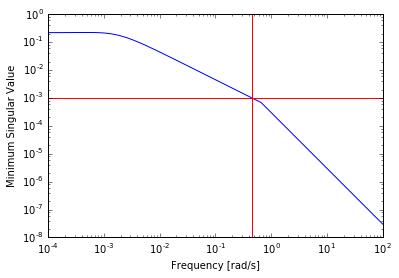

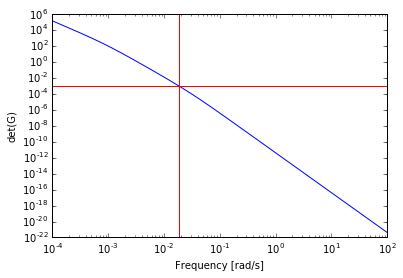

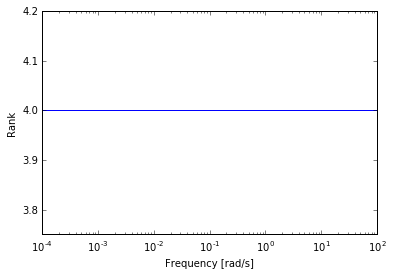

In [13]:
Nu = G.shape[1]
Ny = G.shape[0]
bandwidth_freq, detGzeroFreq = functional_controllability(G_utils_deadtime,Nu,Ny)

In [14]:
print('As seen in the minimum singular value figure, the system is functionally controllable up to frequency of %.3f Hz,\nwhereafter the minimum singular value approaches zero\n' %bandwidth_freq)
print('The determinant of G, however becomes zero at a lower frequency of %.3f Hz'%detGzeroFreq)
print('Lastly, the requirement for functional controllability to maintain full rank across the frequency range appears to hold.')

As seen in the minimum singular value figure, the system is functionally controllable up to frequency of 0.714 Hz,
whereafter the minimum singular value approaches zero

The determinant of G, however becomes zero at a lower frequency of 0.029 Hz
Lastly, the requirement for functional controllability to maintain full rank across the frequency range appears to hold.


# 5. Pole Locations & Directions

In [15]:
def minors(G,order):
    minor = []
    Nrows, Ncols = G.shape
    for rowstokeep in itertools.combinations(range(Nrows),order):
        for colstokeep in itertools.combinations(range(Ncols),order):
            minor.append(utils.det(G[rowstokeep,colstokeep]))
    return minor

def num_denom (A, symbolic_expr = False):
    
    sym_den = 0
    sym_num = 0
        
    if type(A) == utils.mimotf:
        denom   = 1
        num     = 1
        
        for j in range(A.matrix.shape[1]):
            denom = list(np.poly1d(denom) * np.poly1d(A.matrix[0,j].denominator.coeffs))
            num   = list(np.poly1d(num)   * np.poly1d(A.matrix[0,j].numerator.coeffs))
            if symbolic_expr == True:
                for n in range(len(denom)):
                    sym_den = (sym_den + denom[len(denom) - n- 1] * s**n).simplify()
                for n in range(len(num)):
                    sym_num = (sym_num + num[len(num) - n- 1] * s**n).simplify()
                return sym_num, sym_den
            else:
                return num, denom
            
    elif type(A) == utils.tf:
        denom = []
        num = []
            
        denom = [list(A.denominator.coeffs)[n] for n in range(len(list(A.denominator.coeffs)))]
        num   = [list(A.numerator.coeffs)[n] for n in range(len(list(A.numerator.coeffs)))]
        if symbolic_expr == True:
            for n in range(len(denom)):
                sym_den = (sym_den + denom[len(denom) - n - 1] * s**n).simplify()
            for n in range(len(num)):
                sym_num = (sym_num + num[len(num) - n - 1] * s**n).simplify()
            return sym_num, sym_den
        else:
            return num, denom
    else:
        sym_num, sym_den = A.as_numer_denom()
        if not symbolic_expr:
            num_poly   = sp.Poly(sym_num)
            numer      = [float(k) for k in num_poly.all_coeffs()]
            den_poly   = sp.Poly(sym_den)
            denom      = [float(k) for k in den_poly.all_coeffs()]
            return numer, denom
        else:
            return sym_num, sym_den
    
def lcm_of_all_minors(G):
    
    Nrows, Ncols = G.shape
    lcm = 1
    for i in range(1,min(Nrows,Ncols)+1,1):
        allminors = minors(G,i)
        for m in allminors:
            _, sym_den = num_denom (m, symbolic_expr = True)
            lcm = sp.lcm(lcm,sym_den)

    return lcm

def calc_poles(G):
    
    lcm       = lcm_of_all_minors(G)
    lcm_poly  = sp.Poly(lcm)
    lcm_coeff = [float(k) for k in lcm_poly.all_coeffs()]
    pole      = np.roots(lcm_coeff)
        
    return list(set(pole))

def calc_zeros(G,tf_method):
    
    if tf_method == 'det':
        determinant = G.det()
        numer,_ = num_denom (determinant, symbolic_expr = False)
        zero = np.roots(numer)
    elif tf_method == 'minors':
        lcm = lcm_of_all_minors(G)
        allminors = minors(G,G.shape[0])
        gcd = None
        for m in allminors:
            sym_num, sym_den = num_denom (m, symbolic_expr = True)
            if sym_den != lcm:
                sym_num = sym_num * sym_den
            if sym_num.find('s'):
                num_poly   = sp.Poly(sym_num)
                numer      = [float(k) for k in num_poly.all_coeffs()]
                if not gcd:
                    gcd = np.poly1d(numer)
                else:
                    gcd = polygcd(gcd,np.poly1d(numer))
            else:
                gcd = poly1d(numer)

        zero = np.roots(gcd)
    else: raise ValueError('Incorrect solution method for transfer function given')
            
    return list(set(zero))


def RHPonly(x):
    RHPx = []
    for i in range(len(x)):
        if x[i].real >= 0:
            xreal = np.round(x[i].real,2)
            ximag = np.round(x[i].imag,2)
            RHPx.append(complex(xreal,ximag))
    return list(set(RHPx))

def pole_zero_directions(G, pz_vec, dir_type):

    e = 0.000001

    N = len(pz_vec)
    pz_data = []
    Uin  = np.matrix(np.zeros([G.shape[0], N],dtype=complex))
    Yout = np.matrix(np.zeros([G.shape[0], N],dtype=complex))

    if dir_type == 'p':
        dt = 0
    elif dir_type == 'z':
        dt = -1
    else: raise ValueError('Incorrect dir_type parameter')
        
    for i in range(N):
        d = pz_vec[i]
        U, _, V = nplinalg.svd(G(d+e)) 
        u = V[:, dt]
        y = U[:, dt]
        pz_data.append((d, u, y))
        Uin[:,i]  = u
        Yout[:,i] = y
      
    return pz_data, Uin, Yout

The poles of the system are:
	 -0.1
	 -0+0.04j
	 -0-0j
	 0.0
	 -0.1+0.02j
	 0.005+0.03j
	 -0+0.04j
	 -0-0j
	 -0.0
	 -0.1-0j
	 0.005-0j


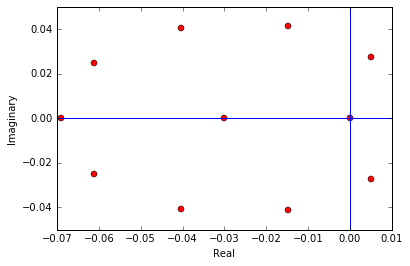


The RHP poles of the system are:
	 0j
	 0.01-0.03j
	 0.01+0.03j


In [16]:
tf_poles    = calc_poles(G_utils_deadtime)
RHPpoles    = RHPonly(tf_poles)

print('The poles of the system are:')
project_utils.print_complex_no(project_utils.round_complex_no(tf_poles))
project_utils.plot_complex(tf_poles)

print('\nThe RHP poles of the system are:')
project_utils.print_complex_no(RHPpoles)

In [17]:
rowheading = ['input direction  ', 'output direction ']
poledata, Up, Yp = pole_zero_directions(G_utils_deadtime, RHPpoles,'p')
project_utils.display_export_data(poledata, 'Poles             ', rowheading)

Poles              | 0.000 | 0.010-0.030j | 0.010+0.030j

input direction  1 |0.190 |0.996 |0.996
input direction  2 |-0.982 |-0.010 |-0.010
input direction  3 |0.017 |-0.093 |-0.093
input direction  4 |-0.000 |-0.001 |-0.001
output direction 1 |-0.471 |-0.316 - 0.948j |-0.316 + 0.948j
output direction 2 |-0.395 |-0.008 - 0.014j |-0.008 + 0.014j
output direction 3 |0.003 |0.012 + 0.041j |0.012 - 0.041j
output direction 4 |-0.789 |0.000 - 0.001j |0.000 + 0.001j



# 6. Zero Locations and Directions

The zeros of the system are:
	 -0.0


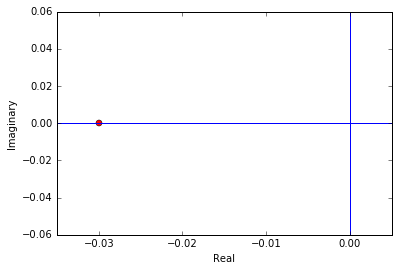


The RHP zeros of the system are:
	 []


In [18]:
tf_zeros    = calc_zeros(G_square,'det')
RHPzeros    = RHPonly(tf_zeros)

print('The zeros of the system are:')
project_utils.print_complex_no(project_utils.round_complex_no(tf_zeros))
project_utils.plot_complex(tf_zeros,axlim = [-0.035, None,None,None])

print('\nThe RHP zeros of the system are:')
project_utils.print_complex_no(RHPzeros)

In [19]:
zerodata, Uz, Yz,  = pole_zero_directions(G_utils_deadtime, tf_zeros,'z')
project_utils.display_export_data(zerodata, 'Zeros             ', rowheading)

Zeros              | -0.030

input direction  1 |0.000
input direction  2 |-0.003
input direction  3 |0.169
input direction  4 |0.986
output direction 1 |0.001
output direction 2 |-0.000
output direction 3 |0.026
output direction 4 |1.000



# 7. RGA & Decentralised Control

In [20]:
def ssRGA(G):
    s = 0
    e = 0.00001
    
    RGA_ss  = utils.RGA(G(s+e))
    RGA_no  = utils.RGAnumber(G(s+e), np.eye(G.shape[0], G.shape[1]))

    return RGA_ss, RGA_no

In [21]:
RGA_ss, RGA_no = ssRGA(G_utils_deadtime)
print("The steady state RGA matrix is:\n", np.matrix.round(RGA_ss))
#print("\nThe steady state RGA number is:\n", RGA_no)
print("\nBased on this result, it would be recommended that the following inputs and outputs are paired:\nu1 to control y1\nu2 to control y2\nu3 to control y3\nu4 to control y4")

The steady state RGA matrix is:
 [[ 1.-0.j -0.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j  1.-0.j]]

Based on this result, it would be recommended that the following inputs and outputs are paired:
u1 to control y1
u2 to control y2
u3 to control y3
u4 to control y4


#### Consider RGA across all frequencies incase this pairing changes

In [22]:
def rga_plot(G, w_start=-2, w_end=2, axlim=None, points=1000, fig=0, plot_type='elements', input_label=None, output_label=None):

    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    dim = G.shape 
    freqresp = [G(si) for si in s]

    if (input_label is None) and (output_label is None):
        labels = False
    elif np.shape(input_label)[0] == np.shape(output_label)[0]:
        labels = True
    else:
        raise ValueError('Input and output label count is not equal')

    for i in range(dim[0]):
        for j in range(dim[1]):
            plt.figure()
            if labels:
                plt.title('Output (%s) vs. Input (%s)' % (output_label[i], input_label[j]))
            else:
                plt.title('Output %s vs. Input %s' % (i + 1, j + 1))

            plt.semilogx(w, np.array(np.abs(([utils.RGA(Gfr)[i, j] for Gfr in freqresp]))))
            plt.axis(axlim)
            plt.ylabel('$|\lambda$$_{%s, %s}|$' % (i + 1, j + 1),fontsize=14)
            plt.xlabel('Frequency')
    plt.show()

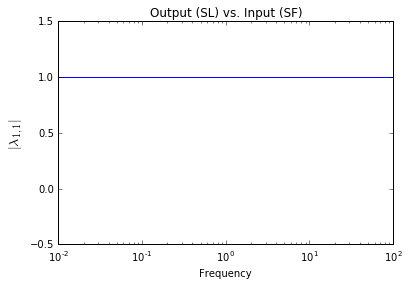

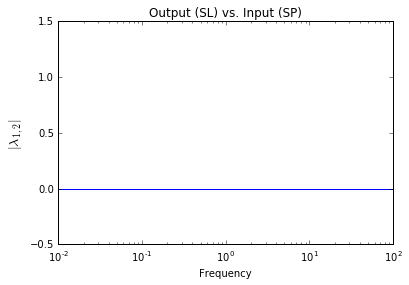

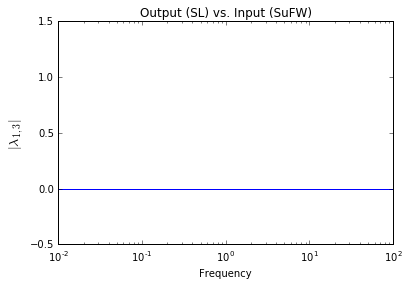

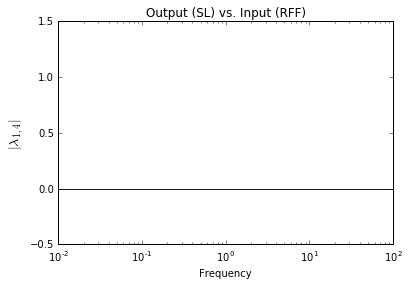

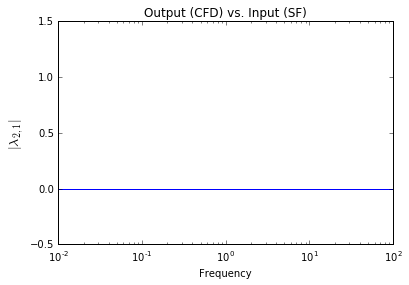

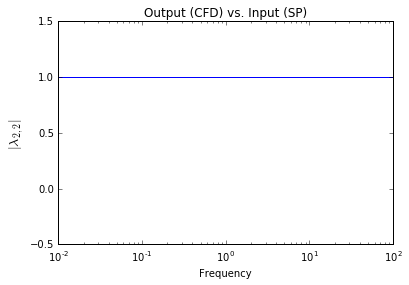

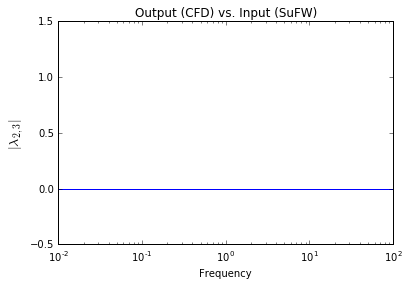

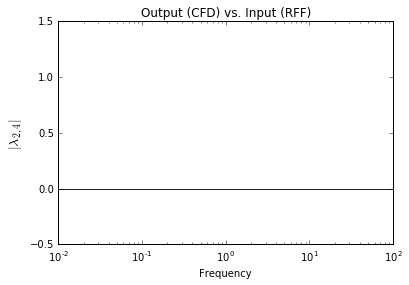

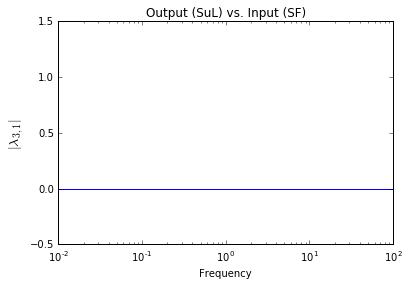

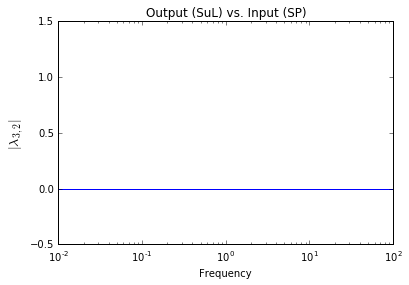

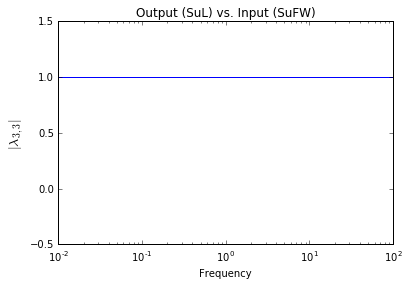

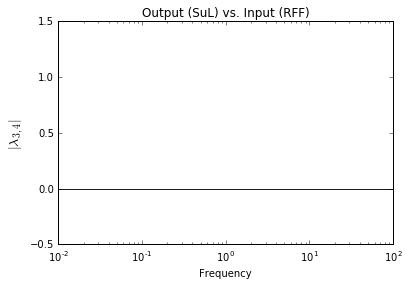

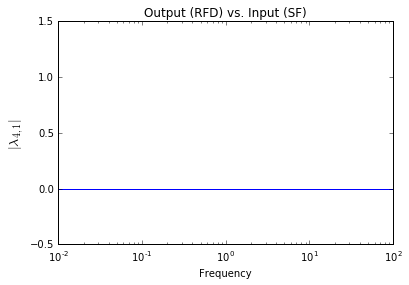

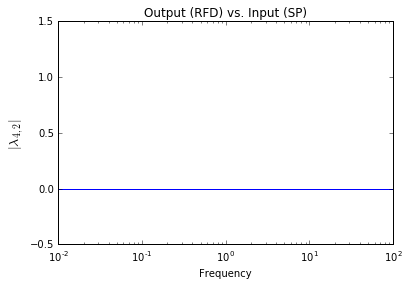

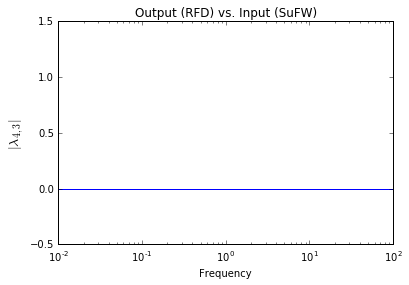

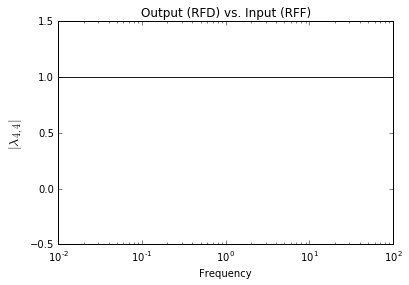

In [23]:
rga_plot(G_utils_deadtime, axlim = [None, None, -0.5, 1.5], input_label = ['SF','SP','SuFW','RFF'], output_label = ['SL','CFD','SuL','RFD'])

Therefore it can be concluded that the suggested input-ouput pairing based on the steady state RGA holds for all frequencies

# 8. Singular Values and Condition Number

In [24]:
def mimo_bode(G, w_start=-2, w_end=2, axlim=None, points=1000, text=False, sv_all=False):

    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    dim = np.shape(G)[0]
    
    crossover = 1
    Sv = np.zeros((len(w), dim), dtype=complex)
    f = False
    wA = 0
    for i in range(len(w)):
        _,Sv[i, :],_ = utils.SVD(G(s[i]))
        if not f:
            if Sv[i, -1] < 1:
                wA = w[i]
                f = True
    ymin = np.min(Sv[:, -1])

    if not sv_all:
        plt.loglog(w, Sv[:, 0], 'b', label=('$\sigma_{max}(G)$'))
        plt.loglog(w, Sv[:, -1], 'g', label=('$\sigma_{min}(G)$'))
        plt.axhline(crossover, ls=':', lw=2, color='r')
        plt.axis(axlim)
        plt.grid()
        plt.xlabel('Frequency [rad/unit time]')
        plt.ylabel('$\sigma$', fontsize = 14)
        plt.legend()
        
    else:
        for j in range(dim):
            plt.figure()
            plt.loglog(w, Sv[:, j], label=('$\sigma_{%s}(G)$' % (j)))
            plt.axis(axlim)
            plt.grid()
            plt.xlabel('Frequency [rad/unit time]')
            plt.ylabel('$\sigma$',fontsize = 16)
            plt.legend()
            plt.axhline(crossover, ls=':', lw=2, color='r')
            plt.axvline(wA, ls=':', lw=2, color='r')

    Bandwidth = wA
    
    return Bandwidth

C:\Users\marcelledk\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\core\numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


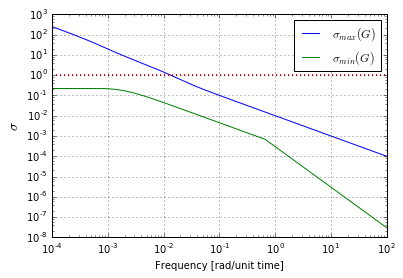

In [25]:
wC = mimo_bode(G_utils_deadtime, w_start = -4, text = True, sv_all=False)
if wC > 10**(-4):
    print("The cossover frequency is:",wC)

### Input & Output directions of Singular Values

In [26]:
def sv_dir_ss(G, table=False, all_dir = False):

    s = 0
    e = 0.000001
    U, Sv, V = utils.SVD(G(s+e))

    u = [U[:, 0]] + [U[:, -1]]
    v = [V[:, 0]] + [V[:, -1]]
    
    if not all_dir:
        if table:
            Headings = ['Maximum', 'Minimum']
            for i in range(2):
                print(' ')
                print('Directions of %s SV' % Headings[i])
                print('-' * 24)

                print('Output vector')
                for k in range(len(u[i])):
                    if np.round(u[i][k].real,5) == 0:
                        if u[i][k].imag < 0:
                            print('%.5fi' % u[i][k].imag)
                        else:
                            print(' %.5fi' % u[i][k].imag)
                    elif np.round(u[i][k].imag,5) == 0:
                        if u[i][k].real < 0:
                            print('%.5f' % u[i][k].real)
                        else:
                            print(' %.5f' % u[i][k].real)
                    else:
                        print('%.5f %+.5fi' % (u[i][k].real, u[i][k].imag))
                print('Input vector')
                for k in range(len(v[i])):
                    if np.round(v[i][k].real,5) == 0:
                        if v[i][k].imag < 0:
                            print('%.5fi' % v[i][k].imag)
                        else:
                            print(' %.5fi' % v[i][k].imag)

                    elif np.round(v[i][k].imag,5) == 0:
                        if v[i][k].real < 0:
                            print('%.5f' % v[i][k].real)
                        else:
                            print(' %.5f' % v[i][k].real)
                    else:
                        print('%.5f %+.5fi' % (v[i][k].real, v[i][k].imag))

                print(' ')
    else:
        sv = (project_utils.round_complex_no(np.eye(len(Sv))*Sv))
        in_vec = project_utils.round_complex_no(V)
        out_vec = project_utils.round_complex_no(U)
        print("The steady state singular values are:\n",np.matrix.round(sv))
        print("Input vector\n",np.matrix.round(in_vec,2))
        print("Output vector\n",np.matrix.round(out_vec,2))

    return u, v

In [27]:
u,v = sv_dir_ss(G_utils_deadtime,table=True,all_dir = True)

The steady state singular values are:
 [[ 24860.+0.j      0.+0.j      0.+0.j      0.+0.j]
 [     0.+0.j   8993.+0.j      0.+0.j      0.+0.j]
 [     0.+0.j      0.+0.j   3056.+0.j      0.+0.j]
 [     0.+0.j      0.+0.j      0.+0.j      0.+0.j]]
Input vector
 [[ 0.20-0.j -1.00-0.j  0.02-0.j -0.00-0.j]
 [-1.00-0.j -0.20-0.j  0.00-0.j -0.00-0.j]
 [-0.00-0.j  0.02-0.j  1.00-0.j -0.20-0.j]
 [ 0.00-0.j -0.00-0.j -0.20-0.j -1.00-0.j]]
Output vector
 [[-0.50+0.j  0.90+0.j -0.00+0.j  0.00+0.j]
 [-0.40+0.j -0.20+0.j  0.01+0.j -0.90+0.j]
 [ 0.00+0.j -0.00+0.j -1.00+0.j  0.00+0.j]
 [-0.80+0.j -0.40+0.j  0.02+0.j  0.40+0.j]]


### Condition Number

In [28]:
def condtn_nm_plot(G, w_start=-2, w_end=2, axlim=None, points=1000):

    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    def cndtn_nm(G):
        return utils.sigmas(G)[0]/utils.sigmas(G)[-1]

    freqresp = [G(si) for si in s]
    CondNum = [cndtn_nm(Gfr) for Gfr in freqresp]
    plt.loglog(w, CondNum , label='$\gamma (G)$')
    plt.axis(axlim)
    plt.ylabel('$\gamma (G)$',fontsize=14)
    plt.xlabel('Frequency [rad/s]',fontsize=12)
    plt.axhline(10., color='red', ls='--', label='"Large" $\gamma (G) = 10$')
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
    
    return CondNum

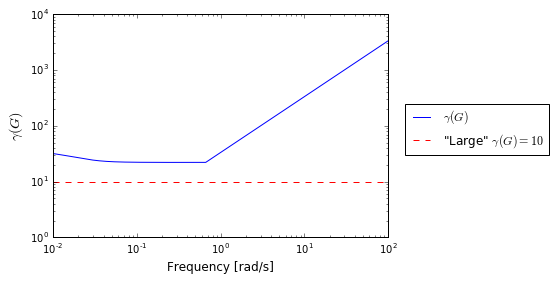

In [29]:
CondNum = condtn_nm_plot(G_utils_deadtime, axlim= [None, None, 10**0, 10**4])

In [30]:
def objective(x,G_hat_square_s):
    e_hat_max = np.array([x[0],x[1],x[2],x[3]])
    De = np.diag(e_hat_max)
    D1 = nplinalg.inv(De)
    u_hat_max = np.array([x[4],x[5],x[6],x[7]])
    D2 = np.diag(u_hat_max)
    G = D1*G_hat_square_s*D2
    Sv = utils.sigmas(G)
    minSv = Sv[-1]
    maxSv = Sv[0]
    return maxSv/minSv

def opt_condtn_nm(G_utils_deadtime,CondNum,scaling_bounds = None):
    omega = np.logspace(-4, 2, 1000)
    min_cond_num = np.zeros((len(omega),1))
    opt_scaling = np.zeros((len(omega),8))
    for w in range(len(omega)):
        if scaling_bounds is None:
            opt = minimize(objective, [20, 0.3, 25, 0.13, 450, 25, 200, 1000], args = (G_utils_deadtime(1j*omega[w])))
        else:
            opt = minimize(objective, [20, 0.3, 25, 0.13, 450, 25, 200, 1000], args = (G_utils_deadtime(1j*omega[w])), bounds = scaling_bounds)

        min_cond_num[w] = opt.fun
        opt_scaling[w,:] = opt.x
        
    return min_cond_num, opt_scaling

In [ ]:
min_cond_num, opt_scaling = opt_condtn_nm(G_utils_deadtime,CondNum)

In [ ]:
omega = np.logspace(-4, 2, 1000)
plt.figure()    
plt.loglog(omega,min_cond_num, label='Optimised Condition Number')
plt.loglog(omega,CondNum,color='red', ls='--',label='Original Condition Number')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Condition Number')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)


original_scaling = [20, 0.3, 25, 0.13, 450, 25, 200, 1000]
var = ['SL','CFD','SuL','RFD','SF','SP','SuFW','RFF']
for i in range(opt_scaling.shape[1]):
    plt.figure()
    plt.semilogx(omega,opt_scaling[:,i],label = 'Optimised Scaling' )
    plt.axhline(original_scaling[i],color='red', ls='--',label='Original Scaling')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel(var[i])
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)


In [ ]:
min_cond_num, opt_scaling = opt_condtn_nm(G_utils_deadtime,CondNum,scaling_bounds = [[None,100],[None,None],[None,100],[None,None],[None,None],[None,100],[None,None],[None,None]])

In [ ]:
plt.figure()    
plt.loglog(omega,min_cond_num, label='Optimised Condition Number')
plt.loglog(omega,CondNum,color='red', ls='--',label='Original Condition Number')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Condition Number')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)


original_scaling = [20, 0.3, 25, 0.13, 450, 25, 200, 1000]
var = ['SL','CFD','SuL','RFD','SF','SP','SuFW','RFF']
for i in range(opt_scaling.shape[1]):
    plt.figure()
    plt.semilogx(omega,opt_scaling[:,i],label = 'Optimised Scaling' )
    plt.axhline(original_scaling[i],color='red', ls='--',label='Original Scaling')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel(var[i])
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)

# 10. Disturbance Limitations on Sensitivity Function

In [31]:
def distRej(G, Gd, w_start=-2, w_end=2, points=1000):

    freq        = np.logspace(w_start,w_end,points)
    gd          = np.zeros((len(freq),Gd.shape[1]))
    yd          = np.zeros((len(freq), Gd.shape[0], Gd.shape[1]), dtype=complex)
    distCondNum = np.zeros((len(freq),Gd.shape[1]))
    freq_min    = np.zeros((1,Gd.shape[1]))
    freq_max    = np.zeros((1,Gd.shape[1]))
    yd_min    = np.zeros((Gd.shape[0],Gd.shape[1]),dtype=complex)
    yd_max    = np.zeros((Gd.shape[0],Gd.shape[1]),dtype=complex)
    
    def func_gd(Gd):
        return 1 / np.linalg.norm(Gd, 2)
    def func_yd(gd,Gd):
        return gd * Gd 
    wd = np.zeros((Gd.shape[1]))
    for cols in range(Gd.shape[1]):
        gd1 = False
        for i in range(len(freq)):
            gd[i,cols] =  func_gd(Gd(1j*freq[i])[:,cols])
            yd[i, :, cols:cols+1] = func_yd(gd[i,cols],Gd(1j*freq[i])[:,cols])  
            _,sv1,_ = (utils.SVD(G(1j*freq[i])))
            _,sv2,_ = utils.SVD(np.linalg.inv(G(1j*freq[i])) * yd[i,:,cols:cols+1])
            distCondNum[i,cols] =  max(sv1) * max(sv2)
            if not gd1 and gd[i,cols] >= 1:
                wd[cols] = freq[i]
                gd1 = True
    
        freq_min[cols] = freq[list(distCondNum[:,cols]).index(min(distCondNum[:,cols]))]
        freq_max[cols] = freq[list(distCondNum[:,cols]).index(max(distCondNum[:,cols]))]
        gd_min         = func_gd(Gd(freq_min[cols])[:,cols])
        gd_max         = func_gd(Gd(freq_max[cols])[:,cols])
        yd_min[:,cols:cols+1]   = func_yd(gd_min,Gd(freq_min[cols])[:,cols])
        yd_max[:,cols:cols+1]   = func_yd(gd_max,Gd(freq_max[cols])[:,cols])
            
    gd_min = gd.min(axis=1)

    return gd_min, yd, yd_min, yd_max, distCondNum, wd

def dis_rejctn_plot(G, Gd, CondNum, w_start=-2, w_end=2, axlim=None, points=1000):

    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    dim = np.shape(Gd)[1] 
    
    gd_min, yd, yd_min, yd_max, condtn_nm_gd, wd = distRej(G, Gd)

    # Equation 6.43
    plt.figure()
    fmin = False
    for i in range(dim):
        plt.loglog(w, condtn_nm_gd[:,i], label=('$\gamma_{d%s} (G)$' % (i+1)))
        
    plt.axis(axlim)
    plt.xlabel('Frequency [rad/s]',fontsize=12)
    plt.ylabel('$\gamma$$_d (G)$',fontsize=14)
    plt.axhline(1., color='red', ls=':', label = ('Good disturbance direction'))
    plt.loglog(w,CondNum, color='red',ls='--', label=('Condition number = bad  direction'))
    plt.legend(loc=2,prop={'size':11})

    # Equation 6.44
    plt.figure()
    plt.loglog(w, gd_min, label=('$1/||g_{d%s}||_2$' % (i+1)))
    plt.axis(axlim)
    plt.axhline(1, color = 'red')
    plt.axvline(wd, color = 'red')
    plt.xlabel('Frequency [rad/s]',fontsize=12)
    plt.ylabel('$||Sy_d||_2$',fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)


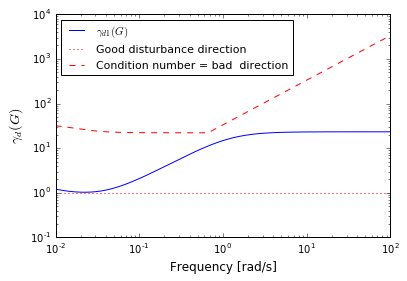

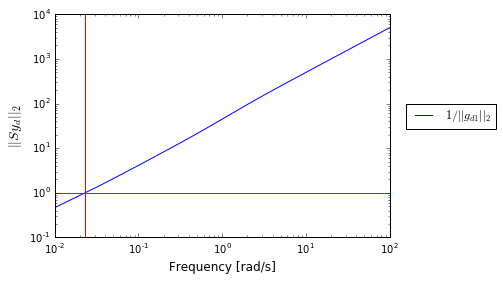

In [32]:
gd_min, yd, yd_min, yd_max, condtn_nm_gd, wd  = distRej(G_utils_deadtime, Gd_utils_deadtime)
dis_rejctn_plot(G_utils_deadtime, Gd_utils_deadtime, CondNum, axlim = [None, None, 10**-1, 10**4])

In [33]:
def distRHPZ(Gd, RHP_Z, Yz):

    if np.real(RHP_Z) < 0:
        raise ValueError('Function only applicable to RHP-zeros')

    Dist_RHPZ_all = np.zeros((len(RHP_Z),Gd.shape[1]))
    Dist_RHPZ     = np.zeros((1,len(RHP_Z)))

    e = 0.00001
    
    for z in range(len(RHP_Z)):
        for cols in range(Gd.shape[1]):
            Dist_RHPZ_all[z,cols] = np.abs(Yz[:,z].H * Gd(RHP_Z[z]+e)[:,cols])
        Dist_RHPZ[0,z] = max(Dist_RHPZ_all[z,:])

    return Dist_RHPZ

In [34]:
#Dist_RHPZ = distRHPZ(Gd_utils_deadtime, RHPzeros, Yz)
#print('Test to see if disturbances are aligned with plant zeros\nDesired: |yz*Gd(z)| < 1\nActual:  |yz*Gd(z)| = %.2f' %Dist_RHPZ)
#print("\nTherefore, the disturbances are not aligned with the plant zeros and control should therefore be possible")
print("The system has no RHP zeros, therefore this criteria cannot be assessed.")

The system has no RHP zeros, therefore this criteria cannot be assessed.


# 11. Disturbance and Input Saturation

### Test for Perfect Control

In [35]:
def input_perfect_control(G, Gd, w_start=-2, w_end=2, points=1000, axlim=None):
    
    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    vec   = np.zeros((len(w),G.shape[1],Gd.shape[1]))
    minSv = np.zeros((1,len(w)))

    #for cols in range(Gd.shape[1]):
    for i in range(len(w)):
        vec[i,:,:] = max(np.linalg.norm(np.linalg.pinv(G(1j*w[i])) * Gd(1j*w[i])),2)
        _,Sv,_ = utils.SVD(G(1j*w[i]))
        minSv[0,i] = min(Sv)

    plt.figure()    
    for col in range(Gd.shape[1]):
        for row in range(G.shape[1]):
            plt.loglog(w, vec[:,row,col],label=('$G^{-1} * Gd  [%s, %s]$' % (row+1,col+1)))
    plt.ylabel('$G^{-1} * Gd$', fontsize=14)
    plt.xlabel('Frequency [rad/s]')
    plt.grid(True)
    plt.axis(axlim)
    plt.legend()

    plt.figure()
    plt.semilogx(w,minSv[0,:])
    plt.ylabel('$\sigma_{min}(G(j\omega))$', fontsize=14)
    plt.xlabel('Frequency [rad/s]')
    plt.grid(True)
    plt.axis([10**w_start, 10**w_end, -0.01, 0.3])


Perfect control (e=0) is not possible, because the minimum singular value remains < 1 for most frequencies
and all elements of the G^-1 * Gd matrix are > 1 across the inverstigated frequency range


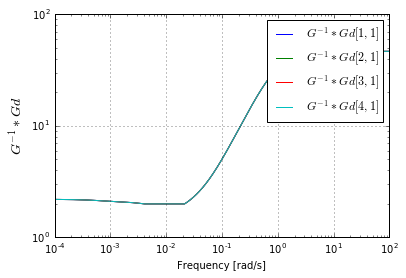

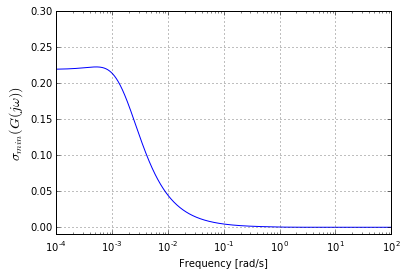

In [36]:
input_perfect_control(G_utils_deadtime, Gd_utils_deadtime, w_start = -4)
print("Perfect control (e=0) is not possible, because the minimum singular value remains < 1 for most frequencies\nand all elements of the G^-1 * Gd matrix are > 1 across the inverstigated frequency range")

### Test for Acceptable Control

In [37]:
def input_acceptable_const_plot(G, Gd, w_start=-2, w_end=2, axlim=None, points=1000, modified=False):

    s, w, axlim = project_utils.frequency_plot_setup(axlim, w_start, w_end, points)

    freqresp = [G(si) for si in s]
    sig = np.array([utils.sigmas(Gfr) for Gfr in freqresp])
    one = np.ones(points)

    dimGd = np.shape(Gd)[1]
    dimG  = np.shape(G)[0]
    
    acceptable_control = np.zeros((points, dimG, dimGd))
    
    for j in range(dimGd):
        for i in range(dimG):
            for k in range(points):
                U, _, _ = utils.SVD(G(s[k]))
                acceptable_control[k, i, j] = np.abs(U[:, i].H * Gd(s[k])[:, j])
            plt.figure()
            if any(ugd < 1 for ugd in acceptable_control[:,i,j]): modified = True
            if not modified:
                plt.loglog(w, sig[:, i], label=('$\sigma_%s$' % (i + 1)))
                plt.loglog(w, acceptable_control[:, i, j] - one, label=('$|u_%s^H.g_{d%s}|-1$' % (i + 1, j + 1)))
            else:
                plt.loglog(w, sig[:, i] + one, label=('$\sigma_%s+1$' % (i + 1)))
                plt.loglog(w, acceptable_control[:, i, j], label=('$|u_%s^H.g_{d%s}|$' % (i + 1, j + 1)))
                plt.axhline(1., color='red', ls=':',label='Applicable', lw = 4)
            
            plt.xlabel('Frequency [rad/s]')
            plt.grid(True)
            plt.axis(axlim)
            plt.legend()


By inspection of the figures illustrating the condition necessary for acceptable control, it can be concluded that:
Acceptable control is only achievable at low frequencies up to approximately 0.005 Hz


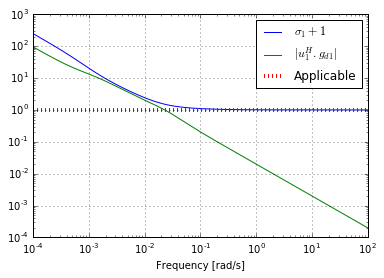

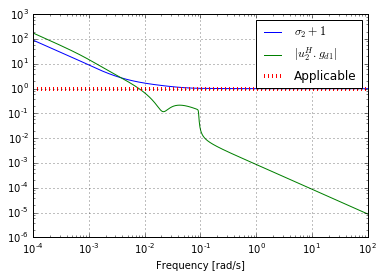

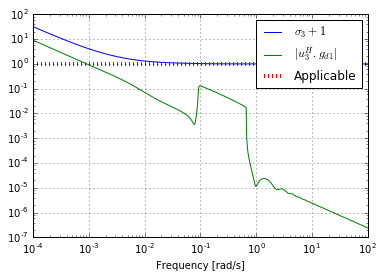

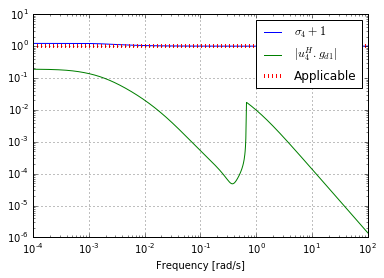

In [38]:
input_acceptable_const_plot(G_utils_deadtime, Gd_utils_deadtime, w_start = -4, modified=True)
print("By inspection of the figures illustrating the condition necessary for acceptable control, it can be concluded that:\nAcceptable control is only achievable at low frequencies up to approximately 0.005 Hz")

# 12. Closed-Loop Transfer Function Bounds

### factorise as  'minimum-phase, stable' version of system

In [39]:
def sens_and_complsens_peaks(poles, pole_dir, zeros, zero_dir, deadtime=None):
    
    Np = len(poles)
    Nz = len(zeros)
    
    Qz  = np.zeros((Nz,Nz),dtype=complex)
    for i in range(Nz):
        for j in range(Nz):
            if zeros[i] == 0 and zeros[j] == 0:
                Qz[i,j] = np.array([1])
            elif (zeros[i] + np.conjugate(zeros[j])) == 0:
                Qz[i,j] = (zero_dir[:,i].H * zero_dir[:,j])
            else:
                Qz[i,j] = (zero_dir[:,i].H * zero_dir[:,j]) / (zeros[i] + np.conjugate(zeros[j]))

    Qp  = np.zeros((Np,Np),dtype=complex)
    for i in range(Np):
        for j in range(Np):
            if poles[i] == 0 and poles[j] == 0:
                Qp[i,j] = np.array([1])
            elif (poles[i] + np.conjugate(poles[j])) == 0:
                c = pole_dir[:,i].H * pole_dir[:,j]
                Qp[i,j] = (pole_dir[:,i].H * pole_dir[:,j])[0,0]
            else:
                Qp[i,j] = ((pole_dir[:,i].H * pole_dir[:,j]) / (np.conjugate(poles[i]) + poles[j]))[0,0]

    Qzp = np.zeros((Nz,Np),dtype=complex)
    for i in range(Nz):
        for j in range(Np):
            if poles[j] == 0 and zeros[i] == 0:
                Qzp[i,j] = np.array([1])
            elif (zeros[i] - poles[j]) == 0:
                Qzp[i,j] = (zero_dir[:,i].H * pole_dir[:,j])[0,0]
            else:
                Qzp[i,j] = ((zero_dir[:,i].H * pole_dir[:,j]) / (zeros[i] - poles[j]))[0,0]


    if deadtime is None:
        pre_mat = scplinalg.sqrtm((nplinalg.inv(Qz))).dot(Qzp).dot(scplinalg.sqrtm(nplinalg.inv(Qp)))
        Ms_min = np.sqrt(1 + (np.max(nplinalg.svd(pre_mat,compute_uv=False))) ** 2)

    else:
        dead_time_vec_max_row = np.zeros(deadtime.shape[0])
        for i in range(deadtime.shape[0]):
            dead_time_vec_max_row[i] = np.max(deadtime[i,:])
            
        def Dead_time_matrix(s, dead_time_vec_max_row):
            dead_time_matrix = np.diag(np.exp(np.multiply(dead_time_vec_max_row, s)))
            return dead_time_matrix

        Q_dead = np.zeros((Np,Np),dtype=complex)
        for i in range(Np):
            for j in range(Np):
                numerator_mat = (pole_dir[:, i].H * Dead_time_matrix(np.conjugate(poles[i]), dead_time_vec_max_row) * \
                                   Dead_time_matrix(poles[j], dead_time_vec_max_row) * pole_dir[:, j])
                denominator_mat = np.conjugate(poles[i]) + poles[j]
                if denominator_mat == 0:
                    Q_dead[i,j] = numerator_mat[0,0]
                else:
                    Q_dead[i,j] = numerator_mat[0,0] / denominator_mat
        
        lambda_mat = sclinalg.sqrtm(nplinalg.pinv(Q_dead)).dot(Qp + (np.asmatrix(Qzp).H).dot(nplinalg.pinv(Qz)).dot(Qzp))\
                                                            .dot(sclinalg.sqrtm(nplinalg.pinv(Q_dead)))

        Ms_min = float(np.real(np.max(nplinalg.eig(lambda_mat)[0])))
        
    return Ms_min


def BoundST(poles, Yp, zeros, Yz, deadtime=None):

    Ms_min = sens_and_complsens_peaks(poles, Yp, zeros, Yz, deadtime=deadtime)
    
    return Ms_min

#### Bound on peak of Complementary Sensitivity function T

In [ ]:
#Ms_min = BoundST(RHPpoles, Yp, RHPzeros, Yz, deadtime=G_theta_square)
#print("The minimum peak achievable for the Complementary Sensitivity (T) function given a system with deadtime is:\n||T|| >= %.2f" % Ms_min)

#### Bound on peak of Sensitivity function S

In [ ]:
#print("For the system given deadtime, the Sensitivtiy function's minimum peak is bounded by:\n%.2f <= M_S,min <= %.2f" % (Ms_min-1, Ms_min+1))

#### Bound on peak of input Complementary Sensitivity  Ti

In [40]:
def BoundSi(poles, Up, zeros, Uz, deadtime=None):
    Ms_min = sens_and_complsens_peaks(poles, Up, zeros, Uz, deadtime=deadtime)
    return Ms_min

In [ ]:
#Si_peak = BoundSi(RHPpoles, Up, RHPzeros, Uz, deadtime=G_deadtime_square)
#print("The minimum peak achievabgle for the input complementary sensitivity (Ti) function iven a system with deadtime is:\nM_Ti,min = %.2f" %Si_peak)

#### Bound on peak of input Sensitivity function Si

In [ ]:
#print("For the system given deadtime, the input Sensitivtiy function's minimum peak is bounded by:\n%.2f <= M_Si,min <= %.2f" % (Si_peak-1, Si_peak+1))

#### Bound on peak of KS

In [41]:
def BoundKSG(G, poles, Up, Yp, e=0.00001, Gd_ms = None):
    
    if Gd_ms == None:
        KSG = []
        Grows, Gcols = G.shape
        for i in range(len(poles)):
            KSG.append(nplinalg.norm(Up[:,i].H * nplinalg.pinv(G(poles[i]+e)), 2))
        KS_max  = np.max(KSG)
    else:
        KSGd = []
        for i in range(len(poles)):
            KSGd.append(np.abs(Up[:,i].H * nplinalg.pinv(G(poles[i] + e)) * Gd_ms(poles[i] + e)))
        KS_max   = np.max(KSGd)

    return KS_max

In [42]:
KSmax = BoundKSG(G_utils, RHPpoles, Up, Yp)
print("The bound on the peak of KS is such that\n||KS|| >= %.2f" %KSmax)

The bound on the peak of KS is such that
||KS|| >= 3.84


#### Bound on peak of KSGd

In [43]:
KSGmax = BoundKSG(G_utils_deadtime, RHPpoles, Up, Yp, Gd_ms = Gd_utils_deadtime)
print("The bound on the peak of KS is such that\n||KSGd|| >= %.2f" %KSGmax)

The bound on the peak of KS is such that
||KSGd|| >= 1.40


#### Bound on peak of SG

In [44]:
def general_peak_bounds(W1, W2, poles, Up, Yp, zeros, Uz, Yz):
    
    Nz = len(zeros)
    Np = len(poles)
    
    Qz1  = np.zeros((Nz,Nz),dtype=complex)
    Qz2  = np.zeros((Nz,Nz),dtype=complex)
    Qp1  = np.zeros((Np,Np),dtype=complex)
    Qp2  = np.zeros((Np,Np),dtype=complex)
    Qzp1 = np.zeros((Nz,Np),dtype=complex)
    Qzp2 = np.zeros((Nz,Np),dtype=complex)
    
    
    for i in range(Nz):
        for j in range(Nz):
            if (zeros[i] + np.conjugate(zeros[i])) == 0:
                Qz1[i,j] = (Yz[:,i].H * nplinalg.pinv(W1(zeros[i])) * nplinalg.pinv(W1(zeros[j])).H * Yz[:,j])[0,0]
                Qz2[i,j] = (Yz[:,i].H * W2(zeros[i]) * W2(zeros[j]) * Yz[:,j])[0,0]
            else:
                Qz1[i,j] = ((Yz[:,i].H * nplinalg.pinv(W1(zeros[i])) * nplinalg.pinv(W1(zeros[j])).H * Yz[:,j]) / (zeros[i] + np.conjugate(zeros[j])))[0,0]
                Qz2[i,j] = ((Yz[:,i].H * W2(zeros[i]) * W2(zeros[j]) * Yz[:,j]) / (zeros[i] + np.conjugate(zeros[j])))[0,0]
    
    for i in range(Np):
        for j in range(Np):
            if (np.conjugate(poles[i]) + poles[j]) == 0:
                Qp1[i,j] = (Yp[:,i].H * W1(poles[i]).H * W1(poles[j]) * Yp[:,j])[0,0]
                Qp2[i,j] = (Yp[:,i].H * nplinalg.pinv(W2(poles[i])).H * nplinalg.pinv(W2(poles[j])) * Yp[:,j])[0,0]
            else:
                Qp1[i,j] = ((Yp[:,i].H * W1(poles[i]).H * W1(poles[j]) * Yp[:,j]) / (np.conjugate(poles[i]) + poles[j]))[0,0]
                Qp2[i,j] = ((Yp[:,i].H * nplinalg.pinv(W2(poles[i])).H * nplinalg.pinv(W2(poles[j])) * Yp[:,j]) / (np.conjugate(poles[i]) + poles[j]))[0,0]
     
    for i in range(Nz):
        for j in range(Np):
            if (zeros[i] + poles[j]) == 0:
                Qzp1[i,j] = (Yz[:,i].H * nplinalg.pinv(W1(zeros[i])) * W1(poles[j]) * Yp[:,j])[0,0]
                Qzp2[i,j] = (Yz[:,i].H * W2(zeros[i]) * nplinalg.pinv(W2(poles[j])) * Yp[:,j])[0,0]
            else:
                Qzp1[i,j] = ((Yz[:,i].H * nplinalg.pinv(W1(zeros[i])) * W1(poles[j]) * Yp[:,j]) / (zeros[i] + poles[j]))[0,0]
                Qzp2[i,j] = ((Yz[:,i].H * W2(zeros[i]) * nplinalg.pinv(W2(poles[j])) * Yp[:,j]) / (zeros[i] + poles[j]))[0,0]
    
    S_mat = sclinalg.sqrtm(nplinalg.pinv(Qz1)).dot(Qz2 + (np.asmatrix(Qzp2)).dot(nplinalg.pinv(Qp2)).dot(np.asmatrix(Qzp2).H))\
                            .dot(sclinalg.sqrtm(nplinalg.pinv(Qz1)))
    T_mat = sclinalg.sqrtm(nplinalg.pinv(Qp2)).dot(Qp1 + (np.asmatrix(Qzp1).H).dot(nplinalg.pinv(Qz1)).dot(Qzp1))\
                            .dot(sclinalg.sqrtm(nplinalg.pinv(Qp2)))
    
    Ms_min = float(sqrt(abs((np.max(nplinalg.eig(S_mat)[0])).real)))
    Mt_min = float(sqrt(abs((np.max(nplinalg.eig(T_mat)[0])).real)))

    return Ms_min, Mt_min

def BoundSG(G_ms, poles, Up, Yp, zeros, Uz, Yz):
    
    e = 0.00001
    
    def W1(s):
        return np.asmatrix(np.eye(G_ms.shape[0]))
    def W2(pz):
        return G_ms(pz + e)
 
    return general_peak_bounds(W1, W2, poles, Up, Yp, zeros, Uz, Yz)

In [ ]:
#SG_peak, _ = BoundSG(G_utils, RHPpoles, Up, Yp, RHPzeros, Uz, Yz)
#print("The bound on the peak of SG is such that\n||SG|| >= %.2f" %SG_peak)

#### Bound on peak of SGd

In [ ]:
#SGd_peak, _ = BoundSG(Gd_utils, RHPpoles, Up, Yp, RHPzeros, Uz, Yz)
#print("The bound on the peak of SGd is such that\n||SGd|| >= %.2f" %SGd_peak)

# Uncertainty Anaylysis of Mill Discharge Circuit

In [45]:
Npoints = 10000
Delta_As = (np.random.rand(Npoints)*2-1 + 
            (np.random.rand(Npoints)*2 - 1)*1j)
valid_values = np.abs(Delta_As) < 1
Delta_As = Delta_As[valid_values]

def nyquist_curve(Gnominal, w, freq, uncertainty = 'additive', axlines = true, axlim = None):
    if uncertainty == 'additive':
        Gp = Gnominal[freq] + w*Delta_As
    elif uncertainty == 'multiplicative':
        Gp = Gnominal[freq] + Gnominal[freq]*w*Delta_As
    
    plt.plot(Gnominal.real, Gnominal.imag, color = 'black')
    plt.scatter(Gp.real,Gp.imag, alpha=0.03)
    
    if axlim == None:
        plt.axis([None, None, None, None])
    else:
        plt.axis(axlim)
    plt.scatter(-1, 0, s=100, color='magenta')
    if axlines:
        plt.axhline(0, color='black')
        plt.axvline(0, color='black')
    plt.xlabel('Re')
    plt.ylabel('Im')

freq_range = np.logspace(-4,2,500)
s = 1j*freq_range

In [46]:
print("SL/SP = ")
G_square_deadtime[0,0]

SL/SP = 


-0.01 
──────
  s   

#### Addive parametric uncertainty

In [47]:
def Gp11(x,s):
    return x[0]/(s*(x[1]*s+1))

def Gn11(param,s):
    return param[0]/(s)

def deviation(x,s,nom_param):
    Gn = Gn11(nom_param,s)
    Gp = Gp11(x,s)
    diff = -1*np.abs((Gp - Gn))
    return diff

result_w11 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w11[i,:] = minimize(deviation, [-0.01, 1], args = (1j*freq_range[i], [-0.01]), bounds = [[-1,-0.001],[0,2]])['fun']


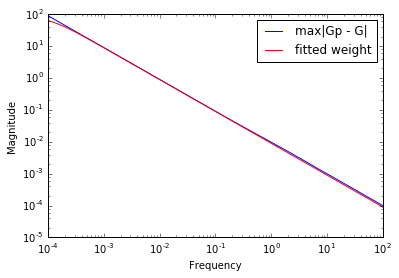

In [ ]:
plt.loglog(freq_range,-result_w11,label = 'max|Gp - G|')

def w11(s):
    return 90*10**(-4)/(s+10**(-4))

plt.loglog(freq_range,np.abs(w11(1j*freq_range)),'r', label = 'fitted weight')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [ ]:
print("SL/SF = ")
G_square_deadtime[0,1]

#### Multiplicative paramtric uncertainty

In [ ]:
def Gp12(x,s):
    return x[0]*np.exp(-x[1]*s)/(s*(x[2]*s+1))

def Gn12(param,s):
    return param[0]*np.exp(-param[1]*s)/(s*(param[2]*s+1))

def deviation(x,s,d,nom_param):
    Gn = Gn12(nom_param,s)
    Gp = Gp12(x,s)
    diff = -1*np.abs((Gp - Gn)/Gn)
    return diff

result_w12 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w12[i,:] = minimize(deviation, [0.01, 121, 90], args = (1j*freq_range[i], 1, [0.01, 121, 90]), bounds = [[0.001,0.1],[100,300],[60,120]])['fun']


In [ ]:
plt.loglog(freq_range,-result_w12,label = 'max|Gp - G|')

def w12(s):
    return 100*(s+0.01)/(6*s+0.1)

plt.loglog(freq_range,np.abs(w12(1j*freq_range)),'r', label = 'fitted weight')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [ ]:
print("CFD/SF = ")
G_square_deadtime[1,1]

#### Multiplicative parametric uncertainty

In [ ]:
def Gp22(x,s):
    return x[0]*np.exp(-x[1]*s)/(s*(x[2]*s+1))

def Gn22(x,s):
    return x[0]*np.exp(-x[1]*s)/(s*(x[2]*s+1))
    
def deviation(x,s,nom_param):
    Gp = Gp22(x,s)
    Gn = Gn22(nom_param,s)    
    diff = -1*np.abs((Gp - Gn)/Gn)
    return diff

result_w22 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w22[i,:] = minimize(deviation, [0.01, 124, 33.33], args = (1j*freq_range[i], [0.01, 124, 33.33]), bounds = [[0.001,10],[100,300],[0,120],])['fun']


In [ ]:
plt.loglog(freq_range,-result_w22,label = 'max|Gp - G|')

def w22(s):
    return  1000*(s+0.03)/0.03

plt.loglog(freq_range,np.abs(w22(1j*freq_range)),'r',label = 'fitted weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [ ]:
print("SuL/SP=")
G_square_deadtime[2,0]

#### Multiplicative parametric and neglected lag uncertainty

In [ ]:
def Gp31(x,s):
    return x[0]*np.exp(-x[1]*s)/(x[2]*s+1)

def Gn31(x,s):
    return x[0]*np.exp(-x[1]*s)/s
    
def deviation(x,s,nom_param):
    Gn = Gn31(nom_param,s)    
    Gp = Gn * Gp31(x,s)
    diff = -1*np.abs((Gp - Gn))
    return diff

result_w31 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w31[i,:] = minimize(deviation, [0.0004,1.258,1], args = (1j*freq_range[i], [0.0004,1.258]), bounds = [[0.0002,1],[0,60],[0,180]])['fun']


In [ ]:
plt.loglog(freq_range,-result_w31,label = 'max|Gp - G|')

def w31(s):
    b = 10**(-4)
    return 8*b/(s+b)

plt.semilogx(freq_range,np.abs(w31(1j*freq_range)),'r',label = 'fitted weight')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [ ]:
print("SuL/RFF=")
G_square_deadtime[2,2]

#### Multiplicative parametric uncertainty

In [ ]:
def Gp33(x,s):
    return x[0]*np.exp(-x[1]*s)/s

def Gn33(param,s):
    return param[0]*np.exp(-param[1]*s)/s
    
def deviation(x,s,nom_param):
    Gn = Gn33(nom_param,s)    
    Gp = Gp33(x,s)
    diff = -1*np.abs((Gp - Gn)/Gn)
    return diff

result_w33 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w33[i,:] = minimize(deviation, [-0.003,6.26], args = (1j*freq_range[i], [-0.003, 6.26]), bounds = [[-1,-0.0003],[0,10]])['fun']


In [ ]:
plt.loglog(freq_range,-result_w33,label = 'max|Gp - G|')
def w33(s):
    return 10*(s+0.00045)/(0.029*s+0.005)
plt.loglog(freq_range,np.abs(w33(1j*freq_range)),'r',label = 'fitted weight')

plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
#def plot_weight(a,b,c,d,e):
#    plt.loglog(freq_range,-result_w33)
#    w33 = a*(b*s+c)/(d*s+e)
#   plt.loglog(freq_range,np.abs(w33),'r')

#i = interact(plot_weight, a=(1, 20, 1), b=(0.1, 1.9, 0.1), c=(0.0001, 0.01, 0.001), d=(0.001, 0.1, 0.001), e =(0.001, 0.1, 0.001))

In [ ]:
print("SuL/SuFW = ")
G_square_deadtime[2,3]

#### Additive parametric uncertainty

In [ ]:
def Gp34(x,s):
    return x[0]*np.exp(-x[1]*s)/s

def Gn34(param,s):
    return param[0]*np.exp(-param[1]*s)/s
    
def deviation(x,s,nom_param):
    Gn = Gn34(nom_param,s)    
    Gp = Gp34(x,s)
    diff = -1*np.abs((Gp - Gn))
    return diff

result_w34 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w34[i,:] = minimize(deviation, [0.0006, 0.415], args = (1j*freq_range[i], [0.0006, 0.415]), bounds = [[0.0006,1],[0,2]])['fun']


In [ ]:
plt.loglog(freq_range,-result_w34,label = 'max|Gp - G|')

def w34(s):
    return 1/(s+10**(-4))

plt.loglog(freq_range,np.abs(w34(1j*freq_range)),'r',label = 'fitted weight')

plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

In [ ]:
print("RFD/SF = ")
G_square_deadtime[3,1]

#### Multiplicative paramtric uncertainty

In [ ]:
def Gp42(x,s):
    return x[0]*np.exp(-x[1]*s)/(s*(x[2]*s**s + x[3]*s + x[4]))

def Gn42(x,s):
    return x[0]*np.exp(-x[1]*s)/(s*(x[2]*s**s + x[3]*s + x[4]))

def deviation(x,s,nom_param):
    Gn = Gn42(nom_param,s)    
    Gp = Gp42(x,s)
    diff = -1*np.abs((Gp - Gn)/Gn)
    return diff

result_w42 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w42[i,:] = minimize(deviation, [0.0006, 126.49, 1422.9, 41.6, 0.03], args = (1j*freq_range[i], [0.0006, 126.49, 1422.9, 41.6, 0.03]), bounds = [[0.0006, 1], [100,200], [1200,1600], [37,46], [0.027,0.033]])['fun']

In [ ]:
plt.semilogx(freq_range,-result_w42,label = 'max|Gp - G|')
def w42(s):
    return (0.1*s+580)/(2*s+5) + 1877
plt.semilogx(freq_range,np.abs(w42(1j*freq_range)),'r',label = 'fitted weight')

plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

#def plot_weight(a,b,c,d,e,f):
#    plt.semilogx(freq_range,-result_w42)
#    w42 = a*(b*s+c)/(d*s+e) + f
#    plt.semilogx(freq_range,np.abs(w42),'r')
#i = interact(plot_weight, a=(1, 10, 0.1), b=(0.1, 1, 0.10), c=(1, 1000, 10), d=(0.1, 20, 0.10), e =(0.1, 10, 0.10),f=(1000, 2000, 1))

In [ ]:
print("RFD/SuFW = ")
G_square_deadtime[3,3]

#### Additive parametric uncertainty

In [ ]:
def Gp44(x,s):
    return x[0]*np.exp(-x[1]*s)/(x[2]*s+1)

def Gn44(x,s):
    return x[0]*np.exp(-x[1]*s)/(x[2]*s + 1)

def deviation(x,s,nom_param):
    Gn = Gn44(nom_param,s)    
    Gp = Gp44(x,s)
    diff = -1*np.abs((Gp - Gn))
    return diff

result_w44 = np.zeros((len(freq_range),1))
for i in range(len(freq_range)):
    result_w44[i,:] = minimize(deviation, [-0.5,5.81,1083.7], args = (1j*freq_range[i], [-0.5, 5.86, 1083.7]), bounds = [[-1,-0.05],[0, 10],[1000,1500]])['fun']

In [ ]:
plt.loglog(freq_range,-result_w44,label = 'max|Gp - G|')
def w44(s):
    return 0.187/(130*s+0.414)
plt.loglog(freq_range,np.abs(w44(1j*freq_range)),'r',label = 'fitted weight')

plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, mode = 'expanded',borderaxespad=0.)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

#def plot_weight(b):
#    plt.loglog(freq_range,-result_w44)
#    w44 = 0.187/(b*s+0.414)
#    plt.loglog(freq_range,np.abs(w44),'r')
#i = interact(plot_weight, b=(0.1, 100, 0.10))